<a href="https://colab.research.google.com/github/SarojiniMaddaraki/AirQualityDetection/blob/main/AirQualityPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.Setup and Library Imports.

In [2]:
# This section ensures all required libraries are installed and imported at the beginning.
# This makes the notebook self-contained and easy to reproduce.

# To install any external libraries not pre-installed in Colab, uncomment the line below:
# !pip install pandas numpy scikit-learn

import pandas as pd
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns

print("All necessary libraries have been imported successfully.")

All necessary libraries have been imported successfully.


2.Data Loading and Initial Inspection.

In [3]:
# We start by loading the dataset from the provided path.
# After loading, we inspect the first few rows and get a summary of the data.

uploaded = files.upload()
!mkdir -p /content/aq
!unzip -o "*.zip" -d /content/aq
!ls -1 /content/aq

PATH = "/content/aq/city_day.csv"
df = pd.read_csv(PATH)

print(f"Initial dataset shape: {df.shape}")
print("\nFirst 5 rows of the raw data:")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))
print("\nDataFrame info:")
df.info()

Saving archive (1).zip to archive (1).zip
Archive:  archive (1).zip
  inflating: /content/aq/city_day.csv  
  inflating: /content/aq/city_hour.csv  
  inflating: /content/aq/station_day.csv  
  inflating: /content/aq/station_hour.csv  
  inflating: /content/aq/stations.csv  
city_day.csv
city_hour.csv
station_day.csv
station_hour.csv
stations.csv
Initial dataset shape: (29531, 16)

First 5 rows of the raw data:
| City      | Date       | PM2.5   | PM10   | NO   | NO2   | NOx   | NH3   | CO   | SO2   | O3     | Benzene   | Toluene   | Xylene   | AQI   | AQI_Bucket   |
|:----------|:-----------|:--------|:-------|:-----|:------|:------|:------|:-----|:------|:-------|:----------|:----------|:---------|:------|:-------------|
| Ahmedabad | 2015-01-01 | nan     | nan    | 0.92 | 18.22 | 17.15 | nan   | 0.92 | 27.64 | 133.36 | 0         | 0.02      | 0        | nan   | nan          |
| Ahmedabad | 2015-01-02 | nan     | nan    | 0.97 | 15.69 | 16.46 | nan   | 0.97 | 24.55 | 34.06  | 3.68   

3.Data Cleaning and Formatting.

In [4]:
# Text for Google Colab:
# Data cleaning is a critical step to ensure data quality. We will make column names
# machine-friendly, convert the 'Date' column to datetime objects, and handle any duplicates.

# Standardize column names
df.columns = [c.strip().lower().replace('.', '_') for c in df.columns]

# Convert 'date' to datetime and sort
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values(['city', 'date']).reset_index(drop=True)

# Remove duplicate rows
before_removal = df.shape[0]
df = df.drop_duplicates().copy()
after_removal = df.shape[0]
print(f"Removed {before_removal - after_removal} duplicate rows.")

# Remove rows with no key data for the prediction task
key_cols = ['pm2_5', 'pm10', 'no2', 'so2', 'co', 'o3', 'aqi']
df = df[df[key_cols].notna().any(axis=1)].copy()
print(f"Remaining rows after cleaning: {df.shape[0]}")

Removed 0 duplicate rows.
Remaining rows after cleaning: 28000


4.Exploratory Data Analysis(EDA) - Missing Values.

Missing values before imputation:
|            | 0     |
|:-----------|:------|
| xylene     | 16727 |
| pm10       | 9609  |
| nh3        | 8803  |
| toluene    | 6659  |
| benzene    | 4239  |
| aqi        | 3150  |
| aqi_bucket | 3150  |
| pm2_5      | 3067  |
| nox        | 2661  |
| o3         | 2491  |
| so2        | 2323  |
| no2        | 2054  |
| no         | 2051  |
| co         | 528   |


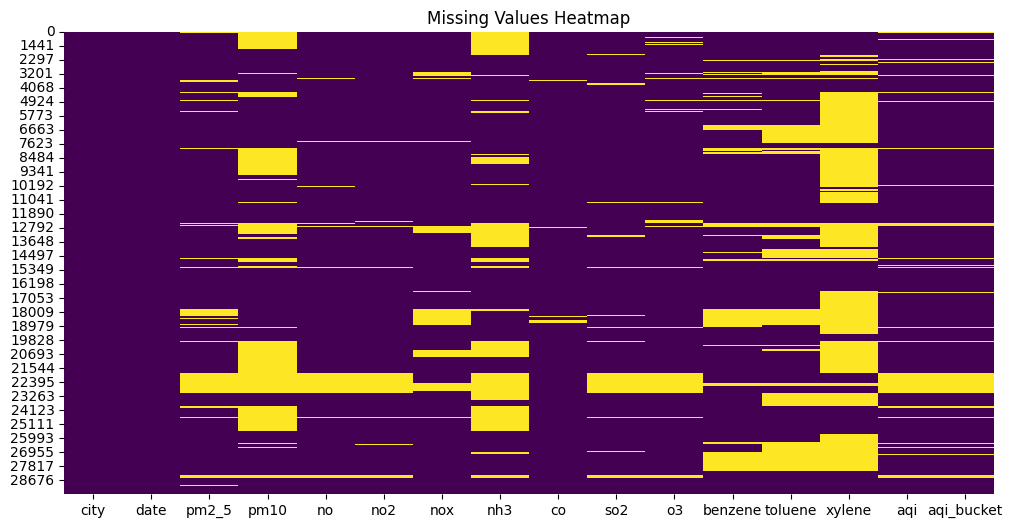

In [5]:
# Text for Google Colab:
# Before imputation, we perform a detailed check of missing values.
# This step helps us choose an appropriate strategy for handling them.

print("Missing values before imputation:")
missing_vals = df.isnull().sum().sort_values(ascending=False)
print(missing_vals[missing_vals > 0].to_markdown(numalign="left", stralign="left"))

# Optional: Visualize the missing data
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

5.Feature Engineering.

In [6]:
# Text for Google Colab:
# Feature engineering involves creating new, meaningful features from existing data.
# This often leads to a significant improvement in model performance.

# Create time-based features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Create rolling mean features for key pollutants
for c in ['pm2_5', 'pm10', 'no2', 'so2', 'o3', 'co']:
    if c in df.columns:
        df[f'{c}_ma3'] = df.groupby('city')[c].transform(lambda x: x.rolling(3, min_periods=1).mean())
        df[f'{c}_ma7'] = df.groupby('city')[c].transform(lambda x: x.rolling(7, min_periods=3).mean())

print("New features have been created successfully.")
print(df.head(3).to_markdown(index=False, numalign="left", stralign="left"))

New features have been created successfully.
| city      | date                | pm2_5   | pm10   | no   | no2   | nox   | nh3   | co   | so2   | o3     | benzene   | toluene   | xylene   | aqi   | aqi_bucket   | year   | month   | day   | day_of_week   | is_weekend   | pm2_5_ma3   | pm2_5_ma7   | pm10_ma3   | pm10_ma7   | no2_ma3   | no2_ma7   | so2_ma3   | so2_ma7   | o3_ma3   | o3_ma7   | co_ma3   | co_ma7   |
|:----------|:--------------------|:--------|:-------|:-----|:------|:------|:------|:-----|:------|:-------|:----------|:----------|:---------|:------|:-------------|:-------|:--------|:------|:--------------|:-------------|:------------|:------------|:-----------|:-----------|:----------|:----------|:----------|:----------|:---------|:---------|:---------|:---------|
| Ahmedabad | 2015-01-01 00:00:00 | nan     | nan    | 0.92 | 18.22 | 17.15 | nan   | 0.92 | 27.64 | 133.36 | 0         | 0.02      | 0        | nan   | nan          | 2015   | 1       | 1     | 3             | 

6.Handling Missing Values((Imputation).

In [7]:
# Text for Google Colab:
# A key challenge is handling missing data. We will use a hierarchical approach
# to fill null values, ensuring the imputation is based on the most relevant data.

num_cols_for_imputation = df.select_dtypes(include=np.number).columns.drop(
    ['year', 'month', 'day', 'day_of_week', 'is_weekend']).tolist()

# Step 1: Impute using city-month median
df[num_cols_for_imputation] = df.groupby(['city', 'month'])[num_cols_for_imputation].transform(
    lambda x: x.fillna(x.median())
)

# Step 2: Impute using city median for any remaining nulls
df[num_cols_for_imputation] = df.groupby('city')[num_cols_for_imputation].transform(
    lambda x: x.fillna(x.median())
)

# Step 3: Impute using global median as a final fallback
df[num_cols_for_imputation] = df[num_cols_for_imputation].fillna(df[num_cols_for_imputation].median())

print("Missing values after imputation:")
print(df.isnull().sum().sort_values(ascending=False).head(10).to_markdown(numalign="left", stralign="left"))

Missing values after imputation:
|            | 0    |
|:-----------|:-----|
| aqi_bucket | 3150 |
| city       | 0    |
| date       | 0    |
| pm10       | 0    |
| pm2_5      | 0    |
| no2        | 0    |
| nox        | 0    |
| nh3        | 0    |
| no         | 0    |
| co         | 0    |


7.Exploratory Data Analysis(EDA) - Visualizations.

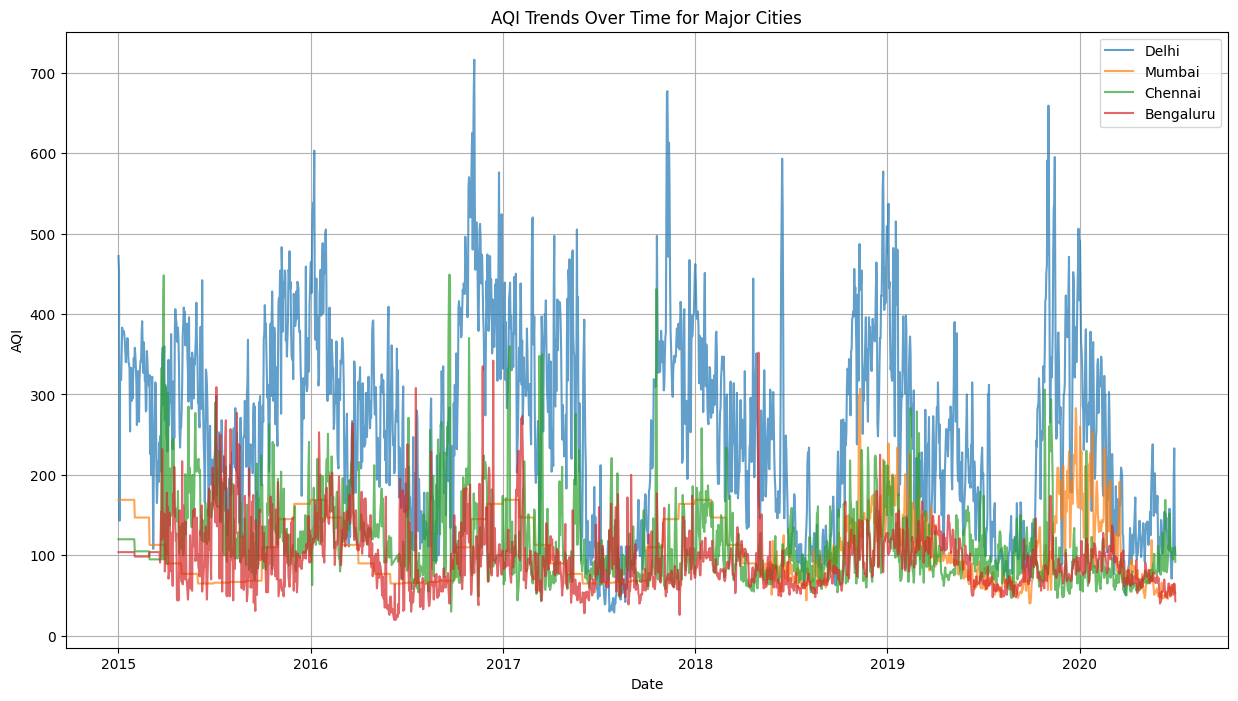

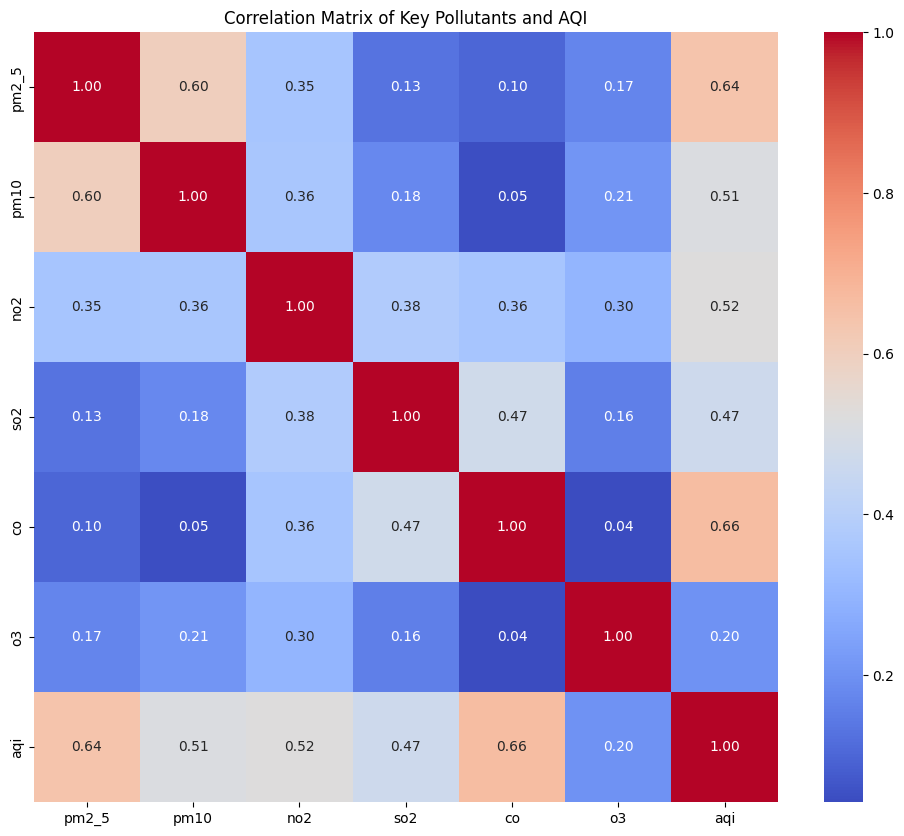

In [8]:
# Text for Google Colab:
# Visualizing data is crucial for understanding trends, distributions, and correlations.
# We will create a few plots to get a better feel for our data.

# Plot a time series for AQI in a few major cities
plt.figure(figsize=(15, 8))
cities_to_plot = ['Delhi', 'Mumbai', 'Chennai', 'Bengaluru']
for city in cities_to_plot:
    city_data = df[df['city'] == city]
    plt.plot(city_data['date'], city_data['aqi'], label=city, alpha=0.7)

plt.title('AQI Trends Over Time for Major Cities')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = df[key_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Pollutants and AQI')
plt.show()

8.Data Splitting For Model Training.

In [9]:
# Text for Google Colab:
# We need to split our data to train and evaluate our machine learning model.
# The training set will be used to teach the model, and the test set will be used
# to check its performance on new, unseen data.

from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
features = df.drop(columns=['city', 'date', 'aqi', 'aqi_bucket'])
target = df['aqi']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (22400, 29)
Testing set shape: (5600, 29)


9.Model Trainig and Evaluation

In [10]:
# Text for Google Colab:
# This part of the notebook will be dedicated to training a machine learning model.
# Here's a simple example using a Random Forest Regressor.

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Mean Absolute Error (MAE): {mae:.2f}")
print(f"Model R-squared (R2) Score: {r2:.2f}")

Model Mean Absolute Error (MAE): 17.26
Model R-squared (R2) Score: 0.89


10. Final Output and Conclusion
The final step is to save cleaned data and summarize the project's findings and next steps.

In [11]:
# Text for Google Colab:
# The final step is to save the cleaned, processed data and summarize our work.
# This cleaned dataset is now ready for more advanced modeling.

OUT_CSV = "/content/clean_city_day.csv"
df.to_csv(OUT_CSV, index=False)
print(f"\nFinal cleaned data saved to: {OUT_CSV}")

# Display conclusion
print("\n--- Project Summary ---")
print("1. Successfully loaded and inspected the dataset.")
print("2. Performed data cleaning, including handling duplicates and re-formatting columns.")
print("3. Engineered new time-based and rolling average features.")
print("4. Implemented a robust hierarchical imputation strategy for missing values.")
print("5. The data is now ready for advanced modeling and analysis.")

# Download the cleaned file to your local machine
from google.colab import files
files.download(OUT_CSV)


Final cleaned data saved to: /content/clean_city_day.csv

--- Project Summary ---
1. Successfully loaded and inspected the dataset.
2. Performed data cleaning, including handling duplicates and re-formatting columns.
3. Engineered new time-based and rolling average features.
4. Implemented a robust hierarchical imputation strategy for missing values.
5. The data is now ready for advanced modeling and analysis.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>